# Analysis of NBA players of the 2021/2022 season

#### Goals of the project:

- Understanding how to query an API to create a dataset with Python and Pandas.
- Cleanup a dataset and generate new fields from calculated data.
- Storing the created dataset in a serialized manner.
- Generating statistics about data.
- Visualizing.

## Introduction

### A brief description of basketball and the NBA

The National Basketball Association is the main basketball league in the United States of America. It currently features 30 teams from different cities, divided in 2 conferences (East and West) of 15 teams. Each team plays a total of 82 games during the regular season. After that, the 8 teams with better records from each conference are seeded in a playoff format, with the winner of each conference playing the finals to determine the eventual champion. NBA seasons usually play out between october of one year, to june of the next year, so for example the current season being played is called the 2021/2022 season.

As in most leagues in the world, the game is played 5 vs 5 players, with as many as 9 reserve players that can rotate with the starters as many times as the team wants. Games are played to 48 minutes, so the total amount of minutes of combined play time for any team in a single game with no added time is 240 minutes. If the score is tied at the end of the 48 minutes, 5 minutes of extra time are played, this continues until a winner is decided.

Even though they can play multiple positions, players are usually classified according to the following positions:

- Guards
    - Point Guards
    - Shooting Guards
- Forwards
    - Small Forwards
    - Power Forwards
- Centers

This project focus on the three main positions: Guards/Forwards/Centers

### 1. Collecting information for building the dataset

To get the information, I'm going to use this API:
 
- https://github.com/swar/nba_api

This is a Python library that can be used to obtain data from stats.nba.com, it provides a set of methods that abstracts you from making the http calls, but directly makes calls to nba stats page and parses the results.
    

In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import commonallplayers
from unidecode import unidecode
from nba_api.stats.endpoints import playercareerstats
import time
from dateutil import relativedelta
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import geopandas as gpd
import folium

In [2]:
def get_and_save_players_list():
    """
    Function to find all ACTIVE players, meaning players that are listed with a team in the 2021/2022 season.
    Save the dataframe to a csv named "nba_current_players_list.csv"
        
    Return
    ------------------------------
    current_players_list: pd.DataFrame
    """

    current_players_list = commonallplayers.CommonAllPlayers().common_all_players.get_data_frame() 
    filter = (current_players_list.PERSON_ID != 1630597) & (current_players_list.PERSON_ID != 1630492) & (current_players_list.GAMES_PLAYED_FLAG != 'N') & (current_players_list.TEAM_ID != 0)
    current_players_list = current_players_list[filter]
    
    return current_players_list

In [3]:
current_players_list = get_and_save_players_list()
current_players_list.to_csv("nba_current_players_list.csv")

In [5]:
def get_players_personal_information(current_players_list: pd.DataFrame) -> pd.DataFrame:
        """
        Function to find the personal information of all players listed in the dataframe created in the previous step, 
        and save it to a csv file named "nba_players_personal_info.csv". The function should also return the created dataframe.

        Parameters
        ------------------------------
        current_player_list: pd.DataFrame
        
        Return
        ------------------------------
        player_personal_info: pd.DataFrame
        """
        pd_lists = [] 

        persons_id = [x for x in current_players_list['PERSON_ID']] # Extract IDs (and save in a list persons_id)

        for id in persons_id: 
                request = commonplayerinfo.CommonPlayerInfo(id).common_player_info.get_data_frame() # Make an API call and use a method to get a DF
                pd_lists.append(request) # Append those API calls outputs into the list (pd_lists) initialized up there
                player_personal_info = pd.concat(pd_lists) # Concat what we have in the list into the DF -> player_personal_info
                time.sleep(1) # Set 1 second between iteration to avoid being blocked by the API


        return player_personal_info

In [6]:
players_personal_info = get_players_personal_information(current_players_list)
players_personal_info.to_csv("nba_players_personal_info.csv")

In [8]:
def get_players_career_stats(current_players_list: pd.DataFrame) -> pd.DataFrame:
    """
    Function to find players career statistics, store the information in a CSV file called "nba_players_career_stats.csv"

    Parameters
    ------------------------------
    current_player_list: pd.DataFrame

    Return
    ------------------------------
    players_career_stats: pd.DataFrame
    """
    pd_lists = []

    for id in current_players_list['PERSON_ID'].values: 
        request = playercareerstats.PlayerCareerStats(player_id=id,per_mode36="PerGame").career_totals_regular_season.get_data_frame()
        pd_lists.append(request)
        players_career_stats = pd.concat(pd_lists)
        time.sleep(1)

    return players_career_stats

In [9]:
players_career_stats = get_players_career_stats(current_players_list)
players_career_stats.to_csv("nba_players_career_stats.csv")

In [11]:
def get_nba_players_salaries(csv_file_path: str) -> pd.DataFrame:
    """
    Function to find players salary for this season. You can get the list of players and salaries from this file: [contracts.csv].

    (https://drive.google.com/file/d/1bxjuIZfMS2_kickukdC3ggdXIVeZE5y7/view?usp=sharing). 

    Download and use the file path as input for this function `get_nba_players_salaries()`.

    Parameters
    ------------------------------
    csv_file_path: str
    """

    contracts = pd.read_csv(csv_file_path, skiprows=[0], index_col=0) 
    contracts.rename(columns={'Player':'PLAYER_NAME', '2021-22':'SALARY'}, inplace=True) # 1st cleaning: rename columns
    contracts['PLAYER_NAME'] = contracts.PLAYER_NAME.str.split('\\', expand=True)[0] # split into 2 columns PLAYER_NAME and keep the first one
    contracts['SALARY'] = contracts.SALARY.str.replace('$','') # erase $ from SALARY column
    contracts.drop_duplicates(subset=['PLAYER_NAME'], inplace=True) 
    contracts['PLAYER_NAME'] = contracts['PLAYER_NAME'].apply(unidecode) # decode special characters from PLAYER_NAME
    contracts = contracts[contracts['PLAYER_NAME'].isin(players_personal_info['DISPLAY_FIRST_LAST'])] # just keep players who are also in the DB of NBA
    contracts.dropna(subset=['SALARY'], inplace=True)
    players_salaries = pd.DataFrame(contracts) # create a df
    

    return players_salaries

In [12]:
players_salaries = get_nba_players_salaries("contracts.csv")
players_salaries.to_csv("nba_players_salary.csv")

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\585971973.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  contracts['SALARY'] = contracts.SALARY.str.replace('$','') # erase $ from SALARY column


In [14]:
def merge_dataframes(players_personal_info: pd.DataFrame, players_career_stats: pd.DataFrame, players_salaries: pd.DataFrame) -> pd.DataFrame:
    """
    Function to merge the created dataframes: players_personal_info, players_career_stats, players_next_game, players_salaries. 

    Columns from each DataFrame to be used: 
    - Players info: "PLAYER_NAME", "TEAM_NAME", "POSITION", "HEIGHT", "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER"
    - Players stats: "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK"
    - Misc: "SALARY"

    Save the result to a csv called "raw_nba_players_dataset.csv"

    Parameters
    ------------------------------
    players_personal_info: pd.DataFrame
    players_career_stats: pd.DataFrame
    players_salaries: pd.DataFrame

    Return
    ------------------------------
    raw_players_dataset: pd.DataFrame
    """
    
    players_personal_info = players_personal_info.rename(columns={'PERSON_ID':'PLAYER_ID','DISPLAY_FIRST_LAST':'PLAYER_NAME'}) 
    first_merge = pd.merge(players_personal_info,players_career_stats, how='inner', on='PLAYER_ID') 
    raw_players_dataset = pd.merge(first_merge, players_salaries, how='outer', on='PLAYER_NAME')
    filters = ["PLAYER_NAME" ,"TEAM_NAME", "POSITION", "HEIGHT", "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER", "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK", "SALARY"]
    raw_players_dataset = raw_players_dataset[filters]

    return raw_players_dataset

In [15]:
raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, players_salaries)
raw_players_dataset.to_csv("raw_nba_players_dataset.csv")

### 2. Data Cleaning and Preprocessing

- Height and weight might need to be converted to the metric system.
- Players that have no team assigned should be removed from the dataset.
- Players with no contracts (meaning they don't have a salary defined) should be removed from the dataset.
- If the "position" data is ambiguous (listed at multiple positions), use the first value.
- If the player does not have height or weight data, I use the average for its position as its value.

In [267]:
def copy_and_delete_nan(players_dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Create a copy of your dataset named "working_df", remove all players with no teams or salary
    
    Parameters
    ------------------------------
    players_personal_info: pd.DataFrame

    Return
    ------------------------------
    working_df: pd.DataFrame
    """
    players_dataset = raw_players_dataset 
    no_team_nor_salary = ['SALARY','TEAM_NAME']
    working_df = players_dataset.dropna(subset=no_team_nor_salary) # Drop players who don't have salary nor team 


    return working_df

In [268]:
working_df = copy_and_delete_nan(raw_players_dataset)

In [270]:
def cast_columns(working_df: pd.DataFrame) -> pd.DataFrame:
    """
    Cast Salary and Birthday columns to its corresponding type (int, datetime)

    Parameters
    ------------------------------
    working_df: pd.DataFrame

    Return
    ------------------------------
    working_df: pd.DataFrame
    """

    working_df.loc[:,'SALARY'] =  working_df['SALARY'].astype('int64')
    working_df.loc[:,'BIRTHDATE'] = pd.to_datetime(working_df['BIRTHDATE'])
    
    
    return working_df

In [271]:
cast_columns(working_df)

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\573090380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.loc[:,'SALARY'] =  working_df['SALARY'].astype('int64')
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\573090380.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.loc[:,'BIRTHDATE'] = pd.to_datetime(working_df['BIRTHDATE'])


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
0,Precious Achiuwa,Raptors,Forward,6-8,225,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280
1,Steven Adams,Grizzlies,Center,6-11,265,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171
2,Bam Adebayo,Heat,Center-Forward,6-9,255,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550
3,Santi Aldama,Grizzlies,Forward-Center,6-11,215,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520
4,LaMarcus Aldridge,Nets,Center-Forward,6-11,250,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Delon Wright,Wizards,Guard,6-5,185,USA,1992-04-26,7,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316
499,Thaddeus Young,Raptors,Forward,6-8,235,USA,1988-06-21,15,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000
500,Trae Young,Hawks,Guard,6-1,164,USA,1998-09-19,4,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471
501,Omer Yurtseven,Heat,Center,6-11,275,Turkey,1998-06-19,1,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065


In [88]:
def convert_height_column(working_df):
    """
    Function that converts the height column from height in feet and inches to centimeters.

    Parameters
    ------------------------------
    working_df: pd.DataFrame

    Return
    ------------------------------
    working_df: pd.DataFrame
    """
    conversions = [30.5, 2.5]
    working_df['HEIGHT'] = working_df['HEIGHT'].apply(lambda x: pd.Series(map(int, x.split('-'))).dot(conversions)) # split '-' and multiply each value in the same order of factors
    working_df['HEIGHT'] = np.ceil(working_df['HEIGHT']) # round up
    working_df['HEIGHT'] = working_df['HEIGHT'].astype(int)
    
    return working_df

In [89]:
convert_height_column(working_df)

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\2232108319.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['HEIGHT'] = working_df['HEIGHT'].apply(lambda x: pd.Series(map(int, x.split('-'))).dot(conversions)) # split '-' and multiply each value in the same order of factors
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\2232108319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['HEIGHT'] = np.ceil(working_df['HEIGHT']) # round up
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\2

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
0,Precious Achiuwa,Raptors,Forward,203,225,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280
1,Steven Adams,Grizzlies,Center,211,265,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171
2,Bam Adebayo,Heat,Center-Forward,206,255,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550
3,Santi Aldama,Grizzlies,Forward-Center,211,215,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520
4,LaMarcus Aldridge,Nets,Center-Forward,211,250,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Delon Wright,Wizards,Guard,196,185,USA,1992-04-26,7,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316
499,Thaddeus Young,Raptors,Forward,203,235,USA,1988-06-21,15,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000
500,Trae Young,Hawks,Guard,186,164,USA,1998-09-19,4,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471
501,Omer Yurtseven,Heat,Center,211,275,Turkey,1998-06-19,1,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065


In [91]:
def convert_weight_column(working_df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that converts the weight column from pounds to kilograms

    Parameters
    ------------------------------
    working_df: pd.DataFrame

    Return
    ------------------------------
    working_df: pd.DataFrame
    """
    working_df['WEIGHT'] = working_df['WEIGHT'].astype(float) 
    working_df['WEIGHT'] *= float(0.453592) # convert weight value from lb to kg
    working_df['WEIGHT'] = np.floor(working_df['WEIGHT'])
    working_df['WEIGHT'] = working_df['WEIGHT'].astype(int)

    return working_df

In [92]:
convert_weight_column(working_df)

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\4200082685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['WEIGHT'] = working_df['WEIGHT'].astype(float)
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\4200082685.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['WEIGHT']  *= float(0.453592) # convert weight value from lb to kg
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\4200082685.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
0,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,2,20,134,18.4,7.2,5.1,0.8,0.4,0.5,2711280
1,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,9,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171
2,Bam Adebayo,Heat,Center-Forward,206,115,USA,1997-07-18,5,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550
3,Santi Aldama,Grizzlies,Forward-Center,211,97,Spain,2001-01-10,1,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520
4,LaMarcus Aldridge,Nets,Center-Forward,211,113,USA,1985-07-19,16,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Delon Wright,Wizards,Guard,196,83,USA,1992-04-26,7,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316
499,Thaddeus Young,Raptors,Forward,203,106,USA,1988-06-21,15,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000
500,Trae Young,Hawks,Guard,186,74,USA,1998-09-19,4,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471
501,Omer Yurtseven,Heat,Center,211,124,Turkey,1998-06-19,1,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065


In [94]:
def add_age_column(working_df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that calculates the age in (years, months, days) and saves it in a new string column named "AGE", example: "22 years, 5 months, 25 days".

    Parameters
    ------------------------------
    working_df: pd.DataFrame

    Return
    ------------------------------
    working_df: pd.DataFrame
    """
    
    working_df.sort_values(by='PLAYER_NAME', inplace=True) # order values by player_name
    
    now = datetime.now() 

    list_of_ages = [] 

    for dates in working_df['BIRTHDATE']: # iterate over birthdates

        year = int(dates.strftime('%Y-%m-%d').split('-')[0]) # set the string format time, split and pick the first(year)/second(month)/third(day)
        #year_to_date = pd.to_datetime(year, format='%Y')
        #delta_years = relativedelta.relativedelta(now,year_to_date)

        month = int(dates.strftime('%Y-%m-%d').split('-')[1])
        #month_to_date = pd.to_datetime(month, format='%m')
        #delta_months = relativedelta.relativedelta(now,month_to_date)

        days = int(dates.strftime('%Y-%m-%d').split('-')[2])
        #days_to_date =  pd.to_datetime(days, format='%d')
        #delta_days = relativedelta.relativedelta(now,days_to_date)
        
        age = date(year,month,days) # set the brithdate in the correct form for each player

        delta = relativedelta.relativedelta(now,age) # now minus birthdate

        to_string = str(f'{delta.years} years, {delta.months} months, {delta.days} days')
        list_of_ages.append(to_string) # append results to the list

        # https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas alternative solution for this


    to_series = pd.Series(list_of_ages) # create a series to the list
    working_df['AGE'] = to_series.values # create a new column and put the data from the series in it
    
    return working_df

In [95]:
add_age_column(working_df)

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\3636322755.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df.sort_values(by='PLAYER_NAME', inplace=True) # order values by player_name
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\3636322755.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['AGE'] = to_series.values # create a new column and put the data from the series in it


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
160,Aaron Gordon,Nuggets,Forward,203,106,USA,1995-09-16,8,4,528,28.9,13.0,6.3,2.5,0.7,0.6,16409091,"26 years, 10 months, 26 days"
199,Aaron Holiday,Hawks,Guard,183,83,USA,1996-09-30,4,23,245,18.2,7.3,1.8,2.4,0.7,0.2,3980551,"25 years, 10 months, 12 days"
333,Aaron Nesmith,Pacers,Guard-Forward,196,97,USA,1999-10-16,2,14,98,12.7,4.2,2.2,0.5,0.4,0.1,3631200,"22 years, 9 months, 26 days"
478,Aaron Wiggins,Thunder,Guard,193,86,USA,1999-01-02,1,55,50,24.2,8.3,3.6,1.4,0.6,0.2,1000000,"23 years, 7 months, 9 days"
204,Al Horford,Celtics,Center-Forward,206,108,Dominican Republic,1986-06-03,15,3,950,32.2,13.7,8.2,3.3,0.8,1.2,27000000,"36 years, 2 months, 8 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Zach Collins,Spurs,Forward-Center,211,113,USA,1997-11-19,4,10,182,17.5,6.0,4.2,1.1,0.3,0.7,6984127,"24 years, 8 months, 23 days"
257,Zach LaVine,Bulls,Guard-Forward,196,90,USA,1995-03-10,8,13,478,31.8,19.8,3.9,3.9,0.9,0.3,19500000,"27 years, 5 months, 1 days"
337,Zeke Nnaji,Nuggets,Forward-Center,206,108,USA,2001-01-09,2,22,83,13.2,4.9,2.6,0.3,0.3,0.2,2498760,"21 years, 7 months, 2 days"
486,Ziaire Williams,Grizzlies,Forward,206,83,USA,2001-09-12,1,10,62,21.7,8.1,2.1,1.0,0.6,0.2,4373160,"20 years, 10 months, 30 days"


In [96]:
def update_position(working_df):
    """
    Function that takes care of the disambiguation of the "POSITION" column. Should replace all positions that are mixed with the first one listed.

    Parameters
    ------------------------------
    working_df: pd.DataFrame

    Return
    ------------------------------
    working_df: pd.DataFrame
    """

    working_df['POSITION'] = working_df['POSITION'].apply(lambda x: x.split('-')[0])

    return working_df

In [97]:
update_position(working_df)

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\4234694915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df['POSITION'] = working_df['POSITION'].apply(lambda x: x.split('-')[0])


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
160,Aaron Gordon,Nuggets,Forward,203,106,USA,1995-09-16,8,4,528,28.9,13.0,6.3,2.5,0.7,0.6,16409091,"26 years, 10 months, 26 days"
199,Aaron Holiday,Hawks,Guard,183,83,USA,1996-09-30,4,23,245,18.2,7.3,1.8,2.4,0.7,0.2,3980551,"25 years, 10 months, 12 days"
333,Aaron Nesmith,Pacers,Guard,196,97,USA,1999-10-16,2,14,98,12.7,4.2,2.2,0.5,0.4,0.1,3631200,"22 years, 9 months, 26 days"
478,Aaron Wiggins,Thunder,Guard,193,86,USA,1999-01-02,1,55,50,24.2,8.3,3.6,1.4,0.6,0.2,1000000,"23 years, 7 months, 9 days"
204,Al Horford,Celtics,Center,206,108,Dominican Republic,1986-06-03,15,3,950,32.2,13.7,8.2,3.3,0.8,1.2,27000000,"36 years, 2 months, 8 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Zach Collins,Spurs,Forward,211,113,USA,1997-11-19,4,10,182,17.5,6.0,4.2,1.1,0.3,0.7,6984127,"24 years, 8 months, 23 days"
257,Zach LaVine,Bulls,Guard,196,90,USA,1995-03-10,8,13,478,31.8,19.8,3.9,3.9,0.9,0.3,19500000,"27 years, 5 months, 1 days"
337,Zeke Nnaji,Nuggets,Forward,206,108,USA,2001-01-09,2,22,83,13.2,4.9,2.6,0.3,0.3,0.2,2498760,"21 years, 7 months, 2 days"
486,Ziaire Williams,Grizzlies,Forward,206,83,USA,2001-09-12,1,10,62,21.7,8.1,2.1,1.0,0.6,0.2,4373160,"20 years, 10 months, 30 days"


In [99]:
working_df.to_csv("nba_players_processed_dataset.csv")

### 3. Analyzing and Visualizing data (EDA)


    - General metrics:
        - Total number of players
        - Number of USA born players
        - Number of foreign players
        - Number of players per position
        - Number of players per team
        - Number of rookies (first year players)
    - Players description
        - Average player age (in years)
        - Youngest player age (as a string, like: "22 years, 5 months, 25 days")
        - Oldest player age (as a string, like: "40 years, 2 months, 3 days")
        - Min and Max players height
        - Average height of players per position
    - Contracts
        - Min and Max salary of all players
        - Mean and Median salary of all players

In [100]:
print("-\033[1m General Metrics")
print("")
print(f"    -\033[1m Total number of players: {working_df['PLAYER_NAME'].nunique()}")
print("")
print(f"    -\033[1m Number of USA born players: {working_df['COUNTRY'][working_df['COUNTRY'] == 'USA'].count()}")
print("")
print(f"    -\033[1m Number of foreign players: {working_df['COUNTRY'][working_df['COUNTRY'] != 'USA'].count()}")
print("")
print("    -\033[1m Number of players per position:")
display(pd.DataFrame(working_df['POSITION'].value_counts()))
print("    -\033[1m Number of players per Team:")
display(pd.DataFrame(working_df['TEAM_NAME'].value_counts()))
print(f"    -\033[1m Number of rookies: {working_df['SEASON_EXP'][working_df['SEASON_EXP'] >= 4].count()}")

- General Metrics

    - Total number of players: 428

    - Number of USA born players: 323

    - Number of foreign players: 105

    - Number of players per position:


,POSITION
Guard,200
Forward,167
Center,61


    - Number of players per Team:


,TEAM_NAME
Lakers,18
Cavaliers,17
Bulls,17
Rockets,17
Raptors,17
76ers,16
Pistons,16
Suns,15
Pelicans,15
Grizzlies,15


    - Number of rookies: 266


In [101]:
print("-\033[1m Players description")
print("")

birthdate_mean = working_df['BIRTHDATE'].mean()
birthdate_mean_to_dt = int(birthdate_mean.strftime('%Y-%m-%d').split('-')[0])

mean_age = date(birthdate_mean_to_dt,1,1)
now = datetime.now()
mean_age_years = relativedelta(now,mean_age).years

print(f"    -\033[1m Average player age (in years): {mean_age_years}")
print("")

print(f"    -\033[1m Youngest player age (as a string): {working_df['AGE'].min()}")
display(working_df[working_df['AGE'] == working_df['AGE'].min()])
print("")

print(f"    -\033[1m Oldest player age (as a string): {working_df['AGE'].max()}")
display(working_df[working_df['AGE'] == working_df['AGE'].max()])
print("")

print(f"    -\033[1m Min and Max players height: Min: {working_df['HEIGHT'].min()}cm / Max: {working_df['HEIGHT'].max()}cm")
display(working_df[working_df['HEIGHT'] == working_df['HEIGHT'].min()])
display(working_df[working_df['HEIGHT'] == working_df['HEIGHT'].max()])
print("")

print(f"    -\033[1m Average height of players per position:")
display(pd.DataFrame(round(working_df.groupby(by='POSITION').mean()['HEIGHT'],2)))
print("")

- Players description

    - Average player age (in years): 27

    - Youngest player age (as a string): 19 years, 10 months, 1 days


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
155,Josh Giddey,Thunder,Guard,203,92,Australia,2002-10-10,1,6,54,31.5,12.5,7.8,6.4,0.9,0.4,5988000,"19 years, 10 months, 1 days"



    - Oldest player age (as a string): 42 years, 2 months, 2 days


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
186,Udonis Haslem,Heat,Forward,203,106,USA,1980-06-09,19,Undrafted,872,24.8,7.5,6.6,0.8,0.5,0.3,2641691,"42 years, 2 months, 2 days"



    - Min and Max players height: Min: 178cm / Max: 221cm


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
81,Facundo Campazzo,Nuggets,Guard,178,88,Argentina,1991-03-23,3,Undrafted,130,20.1,5.6,1.9,3.5,1.1,0.3,3804150,"31 years, 4 months, 19 days"


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
286,Boban Marjanovic,Rockets,Center,221,131,Serbia,1988-08-15,7,Undrafted,286,9.2,5.9,3.8,0.5,0.2,0.3,3500000,"33 years, 11 months, 27 days"
370,Kristaps Porzingis,Wizards,Forward,221,108,Latvia,1995-08-02,6,4,337,30.8,18.9,7.9,1.6,0.7,1.9,31650600,"27 years, 0 months, 9 days"



    - Average height of players per position:


,HEIGHT
POSITION,
Center,211.03
Forward,202.96
Guard,192.82


In [102]:
print('-\033[1m Contracts')
print("")

print(f"    -\033[1m Min and Max salary of all players: \n     Min: ${working_df['SALARY'].min()} / Max: ${working_df['SALARY'].max()}")
display(working_df[working_df['SALARY']== working_df['SALARY'].min()])
display(working_df[working_df['SALARY']== working_df['SALARY'].max()])
print("")

print(f"    -\033[1m Mean and Median salary of all players: \n     Average: ${int(working_df['SALARY'].mean())} / Median: ${int(working_df['SALARY'].quantile(0.5))}")


- Contracts

    - Min and Max salary of all players: 
     Min: $85578 / Max: $45780966


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
195,Haywood Highsmith,Heat,Forward,193,99,USA,1996-12-09,2,None,24,8.5,2.2,1.3,0.3,0.1,0.1,85578,"25 years, 8 months, 2 days"
138,Malik Fitts,Celtics,Forward,196,104,USA,1997-07-04,3,Undrafted,18,4.1,1.3,1.1,0.3,0.0,0.0,85578,"25 years, 1 months, 7 days"


,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
111,Stephen Curry,Warriors,Guard,188,83,USA,1988-03-14,13,7,826,34.3,24.3,4.6,6.5,1.7,0.2,45780966,"34 years, 4 months, 28 days"



    - Mean and Median salary of all players: 
     Average: $9019999 / Median: $4672995


##### 3.2 Relationship between scoring (points per game) and salary of all players, the players positions should also be visible.

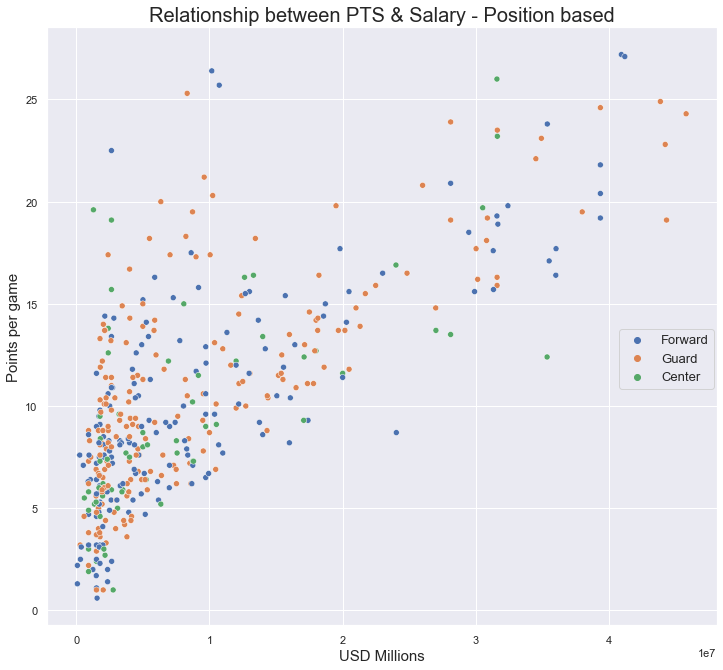

In [103]:
plt.figure(figsize=(12,11))
plt.title('Relationship between PTS & Salary - Position based', fontsize=20)
sns.scatterplot(data=working_df, x='SALARY', y='PTS', hue='POSITION' ,sizes=(30,100), palette='deep')
plt.xlabel('USD Millions', fontsize= 15)
plt.ylabel('Points per game', fontsize= 15)
sns.set_theme(style='darkgrid')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0.2, fontsize=13)


##### 3.3 Assists-vs-salary and rebounding-vs-salary

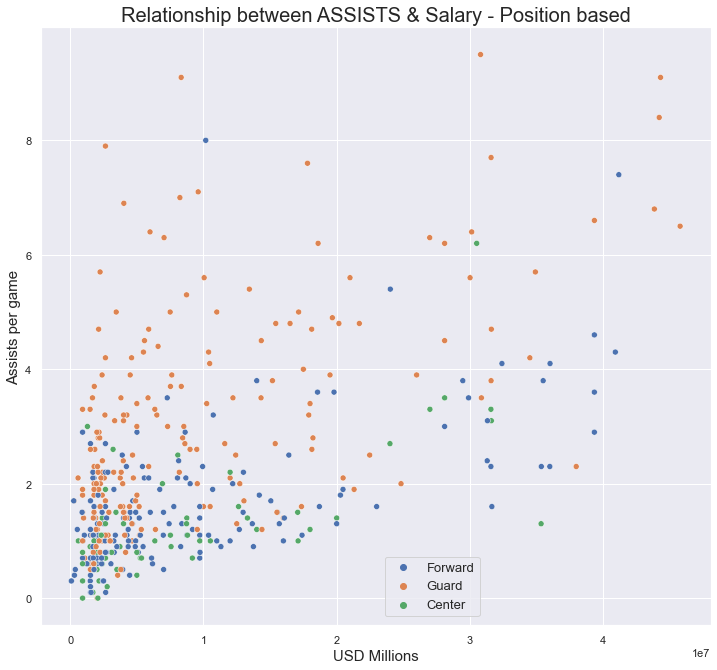

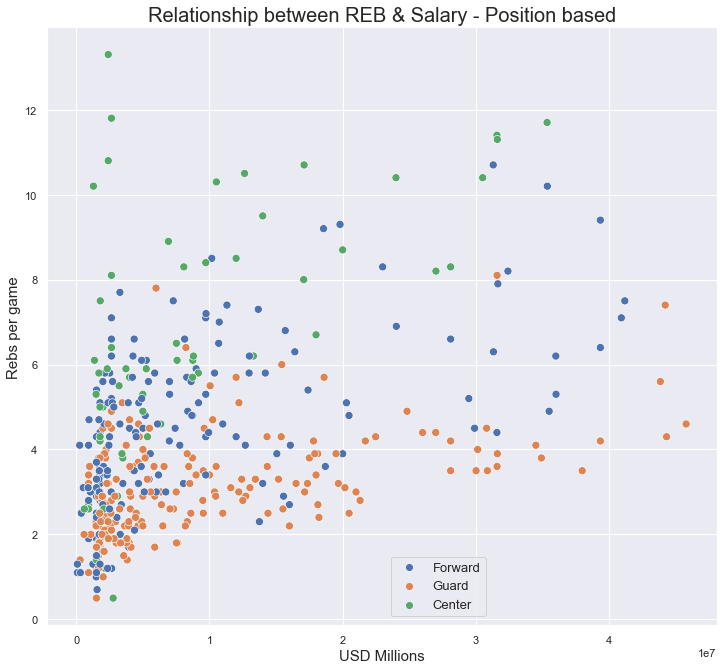

In [104]:
### Complete in this cell: plot assist-vs-salary, rebounding-vs-salary


plt.figure(figsize=(12,11))
plt.title('Relationship between ASSISTS & Salary - Position based', fontsize=20)
sns.scatterplot(data=working_df, x='SALARY', y='AST', hue='POSITION', sizes=(30,100), palette='deep')
plt.xlabel('USD Millions', fontsize= 15)
plt.ylabel('Assists per game', fontsize= 15)
sns.set_theme(style='darkgrid')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0.7, fontsize=13)
plt.show()

plt.figure(figsize=(12,11))
plt.title('Relationship between REB & Salary - Position based', fontsize=20)
sns.scatterplot(data=working_df, x='SALARY', y='REB', hue='POSITION', s=65 ,sizes=(30,100), palette='deep')
plt.xlabel('USD Millions', fontsize= 15)
plt.ylabel('Rebs per game', fontsize= 15)
sns.set_theme(style='darkgrid')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0.7, fontsize=13)
plt.show()

##### 3.4 When NBA players enter the league, they have low value salaries during what is called their "rookie contract". This means that it doesn't matter how well the player performs, they can't have large salaries. This can distort our understanding of how much teams value each skill, as a player could score 50 points a game and still earn just a couple of millions. So, lets now plot points, assists and rebounding vs salary, but only for players that have more than 4 years of experience (the typical length of a rookie contract).

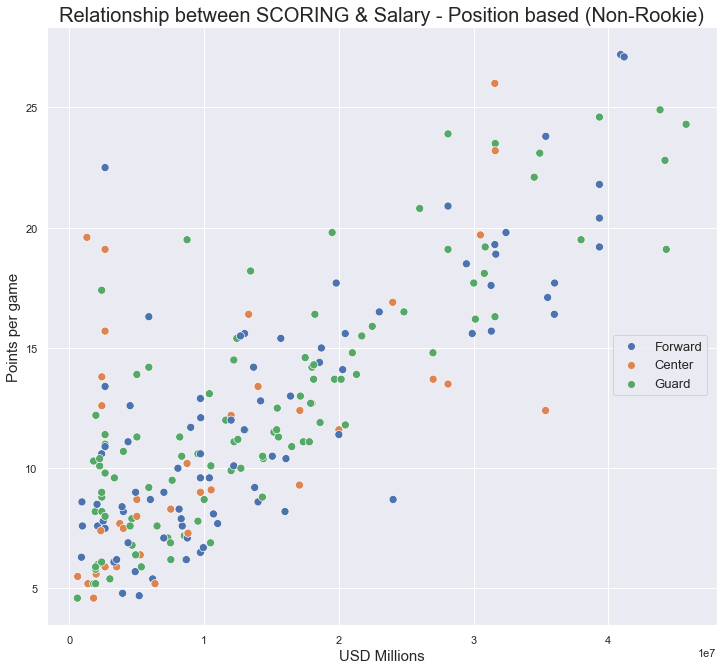

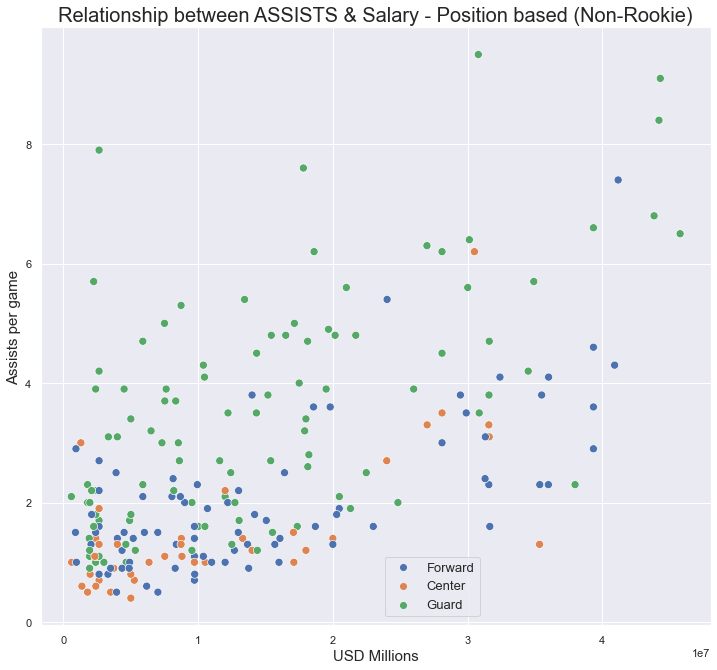

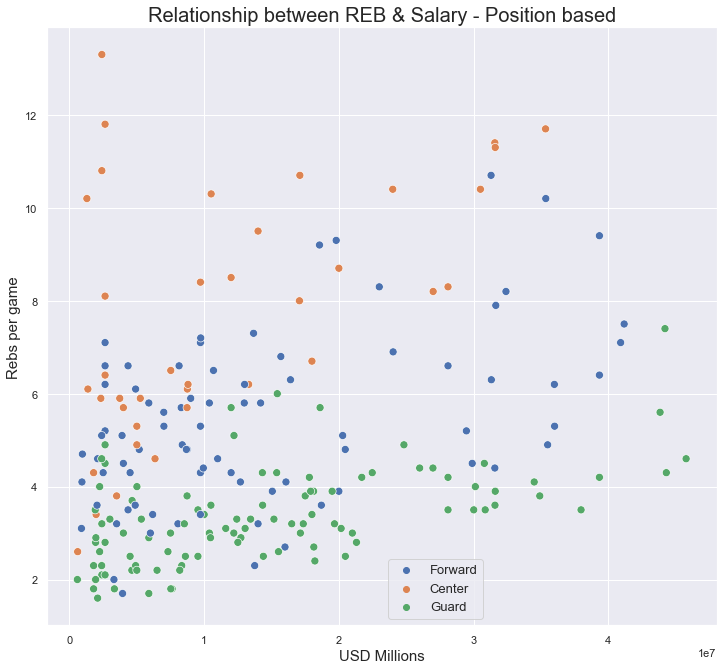

In [107]:
working_df_rookies = working_df.copy()
working_df_rookies = working_df_rookies[working_df_rookies['SEASON_EXP'] > 4] #Non-Rookie Players (More than 4 years in the league)


#1st plot: Scoring VS Salary (Non-Rookie)
plt.figure(figsize=(12,11))
plt.title('Relationship between SCORING & Salary - Position based (Non-Rookie)', fontsize=20)
sns.scatterplot(data=working_df_rookies, x='SALARY', y='PTS', hue='POSITION',s=65,sizes=(30,100), palette='deep')
plt.xlabel('USD Millions', fontsize= 15)
plt.ylabel('Points per game', fontsize= 15)
sns.set_theme(style='darkgrid')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0.7, fontsize=13)
plt.show()

#2nd plot: Assits VS Salary (Non-Rookie)
plt.figure(figsize=(12,11))
plt.title('Relationship between ASSISTS & Salary - Position based (Non-Rookie)', fontsize=20)
sns.scatterplot(data=working_df_rookies, x='SALARY', y='AST', hue='POSITION',s=65, sizes=(30,100), palette='deep')
plt.xlabel('USD Millions', fontsize= 15)
plt.ylabel('Assists per game', fontsize= 15)
sns.set_theme(style='darkgrid')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0.7, fontsize=13)
plt.show()

#3rd plot: Rebounds vs Salary (Non-Rookie)
plt.figure(figsize=(12,11))
plt.title('Relationship between REB & Salary - Position based', fontsize=20)
sns.scatterplot(data=working_df_rookies, x='SALARY', y='REB', hue='POSITION',s=65 ,sizes=(30,100), palette='deep')
plt.xlabel('USD Millions', fontsize= 15)
plt.ylabel('Rebs per game', fontsize= 15)
sns.set_theme(style='darkgrid')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0.5, fontsize=13)
plt.show()




##### 3.5 Scoring average grouped by position, we want to be able to see median, quartiles, etc 

Text(0, 0.5, 'POSITION')

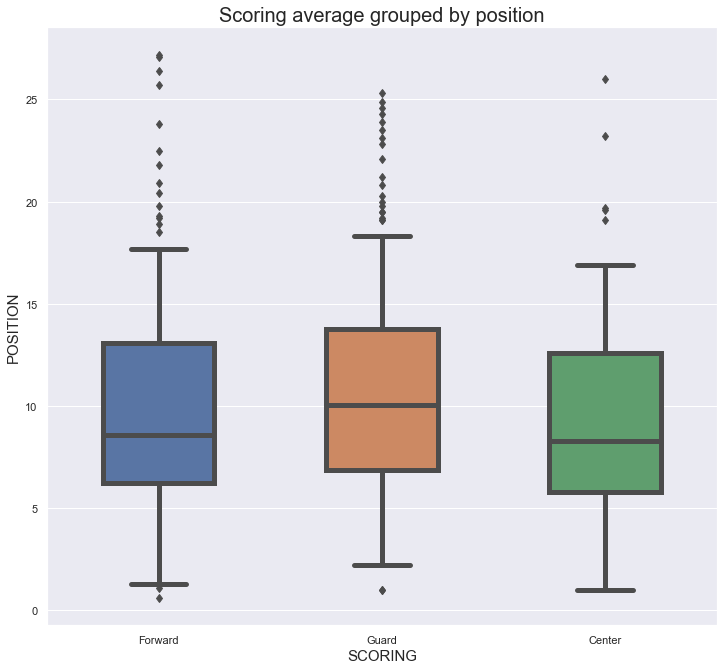

In [108]:
plt.figure(figsize=(12,11))
plt.title('Scoring average grouped by position', fontsize=20)
sns.boxplot(x="POSITION", y="PTS", data=working_df,linewidth=5,whis=0.75,width=0.5,fliersize=6)
plt.xlabel('SCORING', fontsize= 15)
plt.ylabel('POSITION', fontsize= 15)

##### 3.6 Height distribution of all players

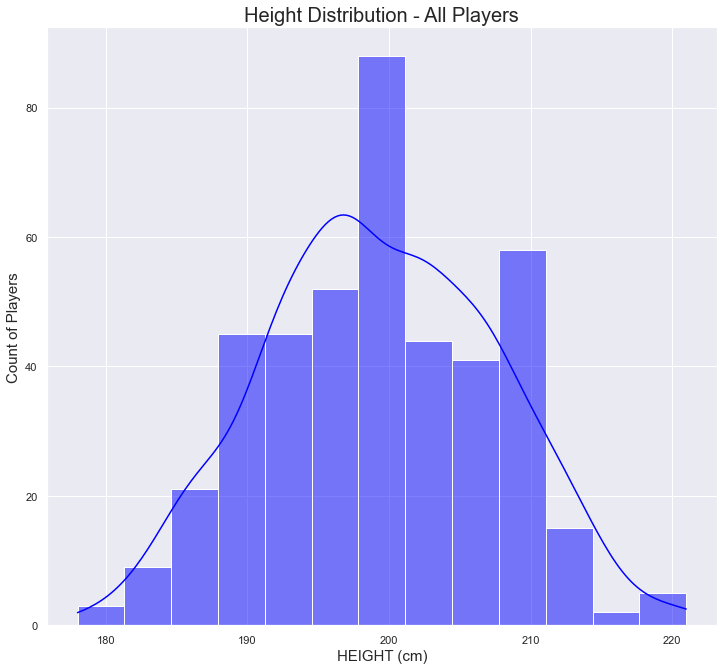

In [ ]:
plt.figure(figsize=(12,11))
plt.title('Height Distribution - All Players', fontsize=20)
sns.histplot(data=working_df['HEIGHT'], kde= True,color="blue")
plt.xlabel('HEIGHT (cm)', fontsize= 15)
plt.ylabel('Count of Players', fontsize= 15)
sns.set_theme(style='dark')

##### Distribution of active NBA Players per country

C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\320305545.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('Bosnia and Herzegovina','Bosnia and Herz.')
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\320305545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('USA','United States of America')
C:\Users\Fede\AppData\Local\Temp\ipykernel_3736\320305545.py:17: SettingWithCopyWarning

<AxesSubplot:title={'center':'Distribution of active NBA Players per country'}>

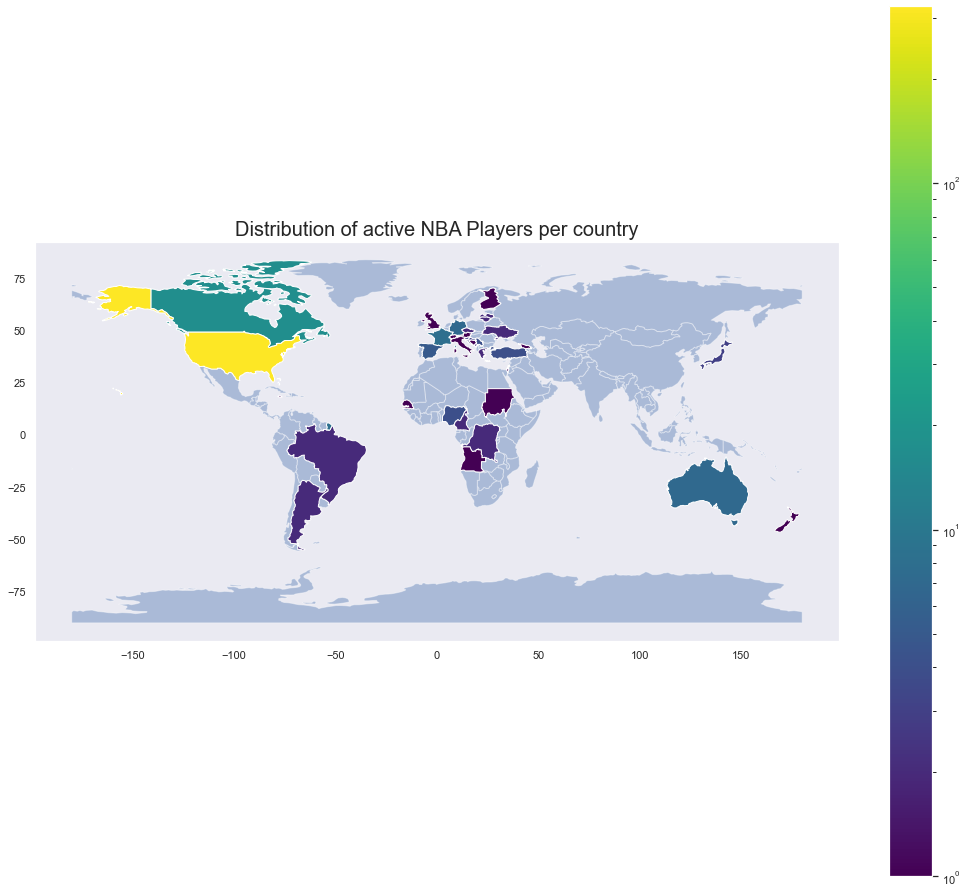

In [ ]:
# get a frame with data as geometry, names of the countries, iso names, etc.
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
for_geo_pandas = working_df # create an object to work on plot

# Rename some values to make a proper merge. (i.e: 'USA' to 'United States of America')
# For the sake of simplicity, 'Saint Lucia' was merged with Bahamas 
# (Saint Lucia shares the same geographical space with Bahamas, but does not appear in our world_map frame)

for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('Bosnia and Herzegovina','Bosnia and Herz.')
for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('USA','United States of America')
for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('Czech Republic','Czechia') 
for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('DRC','Dem. Rep. Congo')
for_geo_pandas['COUNTRY'] = for_geo_pandas['COUNTRY'].replace('Saint Lucia','Bahamas')

# Create a series of values per country, rename column and create index
countries_and_players = pd.DataFrame(for_geo_pandas.COUNTRY.value_counts(), columns=['COUNTRY'])
countries_and_players.rename(columns={'COUNTRY':'NUMBER_OF_PLAYERS'},inplace=True)
countries_and_players['COUNTRY'] = countries_and_players.index

# Merge world_map with for_geo_pandas
merge_to_plot= world_map.merge(countries_and_players, how="left", left_on=['name'], right_on=['COUNTRY'])
merge_to_plot.dropna(subset='NUMBER_OF_PLAYERS', inplace=True) # tidy up which has no value (nan)
merge_to_plot.reset_index(inplace=True) # reset index to order rows


fig, ax = plt.subplots(figsize=(18,16))
plt.title('Distribution of active NBA Players per country', fontsize=20)
world_map.plot(ax=ax, alpha=0.4)
merge_to_plot.plot(column='NUMBER_OF_PLAYERS', ax=ax, cmap='viridis', legend=True, norm=matplotlib.colors.LogNorm(vmin=merge_to_plot.NUMBER_OF_PLAYERS.min(), vmax=merge_to_plot.NUMBER_OF_PLAYERS.max()))
